In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib

In [2]:
import warnings
warnings.filterwarnings("ignore")

## 데이터 로드

In [3]:
# CSV 파일 로드
df = pd.read_csv('krw-btc-201709-202409.csv', index_col=0, parse_dates=True)

## 2023년 9월부터 상승상이었기 때문에 관련 날짜부터 로드

In [4]:
df_2024 = df['2023-09-01':'2024-04-30']

In [5]:
# 5일 이동평균 계산
# 일일 데이터로 리샘플링
df_2024_daily = df_2024.resample('D').agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last', 'volume': 'sum', 'value': 'sum'})

# 일일 데이터에 대한 이동평균 계산
df_2024_daily['MA5'] = df_2024_daily['close'].rolling(window=5).mean()
df_2024_daily['MA20'] = df_2024_daily['close'].rolling(window=20).mean()
df_2024_daily['MA60'] = df_2024_daily['close'].rolling(window=60).mean()
# 1일 변동성 계산
df_2024_daily['변동성'] = (df_2024_daily['high'] - df_2024_daily['low']) / df_2024_daily['open'] * 100

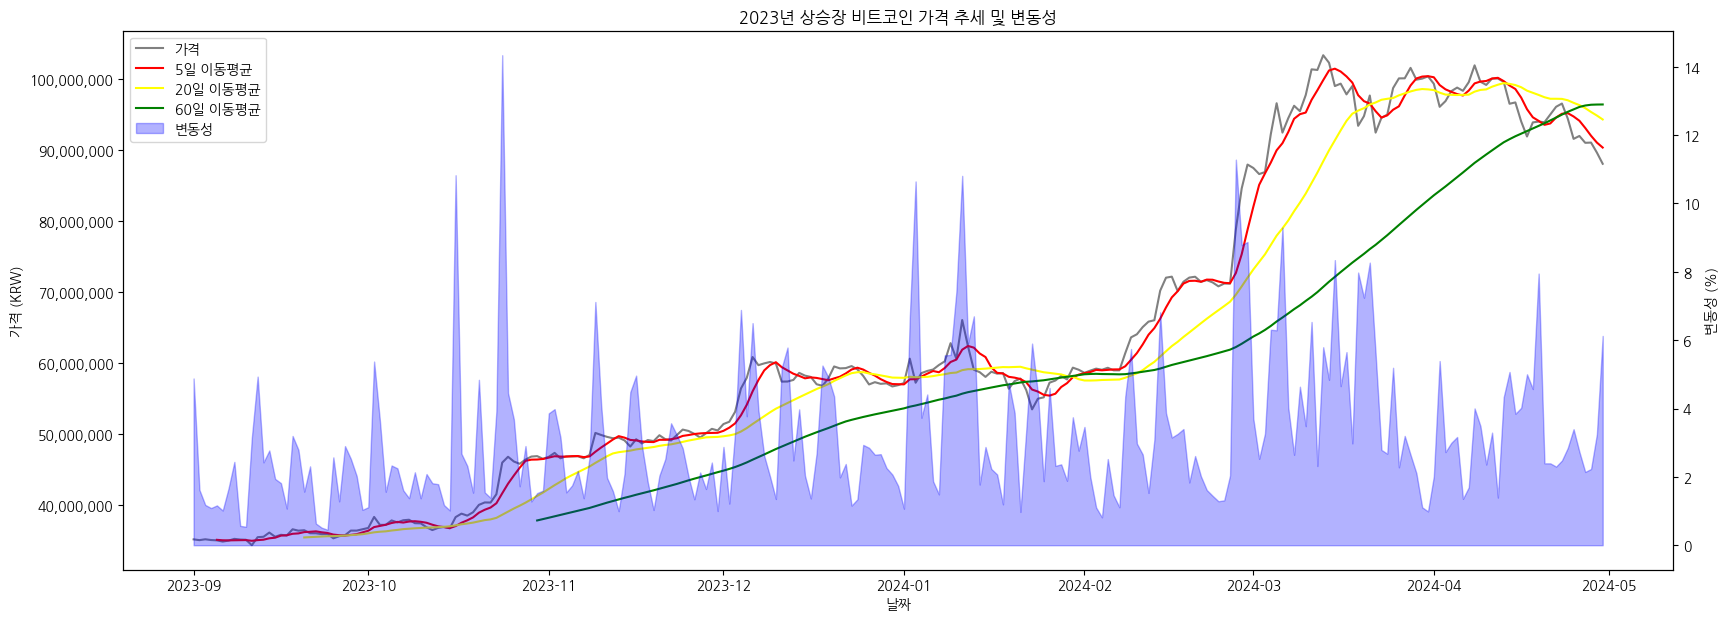

In [6]:
# 그래프 그리기
fig, ax1 = plt.subplots(figsize=(20, 7))

# 가격과 이동평균선 그리기
ax1.plot(df_2024_daily.index, df_2024_daily['close'], label='가격', color='gray')
ax1.plot(df_2024_daily.index, df_2024_daily['MA5'], label='5일 이동평균', color='red')
ax1.plot(df_2024_daily.index, df_2024_daily['MA20'], label='20일 이동평균', color='yellow')
ax1.plot(df_2024_daily.index, df_2024_daily['MA60'], label='60일 이동평균', color='green')

ax1.set_xlabel('날짜')
ax1.set_ylabel('가격 (KRW)')
ax1.tick_params(axis='y')

# Y축 값을 단축하지 않고 실제 수치로 표시하며 세 자리마다 쉼표 추가
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# 변동성 데이터를 위한 두 번째 Y축 생성
ax2 = ax1.twinx()
ax2.fill_between(df_2024_daily.index, df_2024_daily['변동성'], alpha=0.3, color='blue', label='변동성')
ax2.set_ylabel('변동성 (%)')
ax2.tick_params(axis='y')

# 범례 통합
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('2023년 상승장 비트코인 가격 추세 및 변동성')
plt.show()

In [15]:
def backtest_strategy(fee_rate, slippage_rate, print_results=False, return_data=False):
    # 초기 자본 설정
    initial_capital = 10_000_000  # 1,000만원
    capital = initial_capital
    position = 0  # 보유 현금
    holding = 0  # 보유 비트코인 수량
    entry_price = 0  # 매수 가격
    portfolio_values = []  # 포트폴리오 가치 저장
    stop_loss = 0.05  # 5% 손실 제한

    # 매매 신호 생성 (예: MA5가 MA20을 상향 돌파 시 매수, 하향 돌파 시 매도)
    df_2024_daily['Signal'] = 0
    df_2024_daily['Signal'][df_2024_daily['MA5'] > df_2024_daily['MA20']] = 1
    df_2024_daily['Signal'][df_2024_daily['MA5'] < df_2024_daily['MA20']] = -1

    for idx, row in df_2024_daily.iterrows():
        price = row['close']
        signal = row['Signal']

        # 포트폴리오 가치 업데이트
        portfolio_value = capital + holding * price
        portfolio_values.append(portfolio_value)

        # 매수 조건
        if signal == 1 and holding == 0:
            # 슬리피지 적용
            buy_price = price * (1 + slippage_rate)
            # 수수료를 고려한 매수 가능 수량 계산
            holding = (capital / buy_price) / (1 + fee_rate)
            entry_price = buy_price
            capital = 0
            if print_results:
                print(f"{idx.date()} 매수: {holding:.8f} 비트코인 at {buy_price:,.0f} KRW")

        # 매도 조건
        elif signal == -1 and holding > 0:
            # 슬리피지 적용
            sell_price = price * (1 - slippage_rate)
            capital = holding * sell_price * (1 - fee_rate)
            if print_results:
                print(f"{idx.date()} 매도: {holding:.8f} 비트코인 at {sell_price:,.0f} KRW")
            holding = 0

        # 손절 조건
        elif holding > 0 and (price <= entry_price * (1 - stop_loss)):
            # 슬리피지 적용
            sell_price = price * (1 - slippage_rate)
            capital = holding * sell_price * (1 - fee_rate)
            if print_results:
                print(f"{idx.date()} 손절 매도: {holding:.8f} 비트코인 at {sell_price:,.0f} KRW")
            holding = 0

    # 최종 포트폴리오 가치 업데이트
    final_portfolio = capital + holding * df_2024_daily['close'].iloc[-1]
    portfolio_values[-1] = final_portfolio

    # 포트폴리오 가치 데이터프레임 생성
    df_2024_daily['Portfolio'] = portfolio_values

    # ROI 계산
    roi = (final_portfolio - initial_capital) / initial_capital * 100

    if print_results:
        print(f"초기 자본: {initial_capital:,.0f} KRW")
        print(f"최종 포트폴리오 가치: {final_portfolio:,.0f} KRW")
        print(f"ROI: {roi:.2f}%")

    if return_data:
        return df_2024_daily, final_portfolio, initial_capital, roi
    else:
        return roi

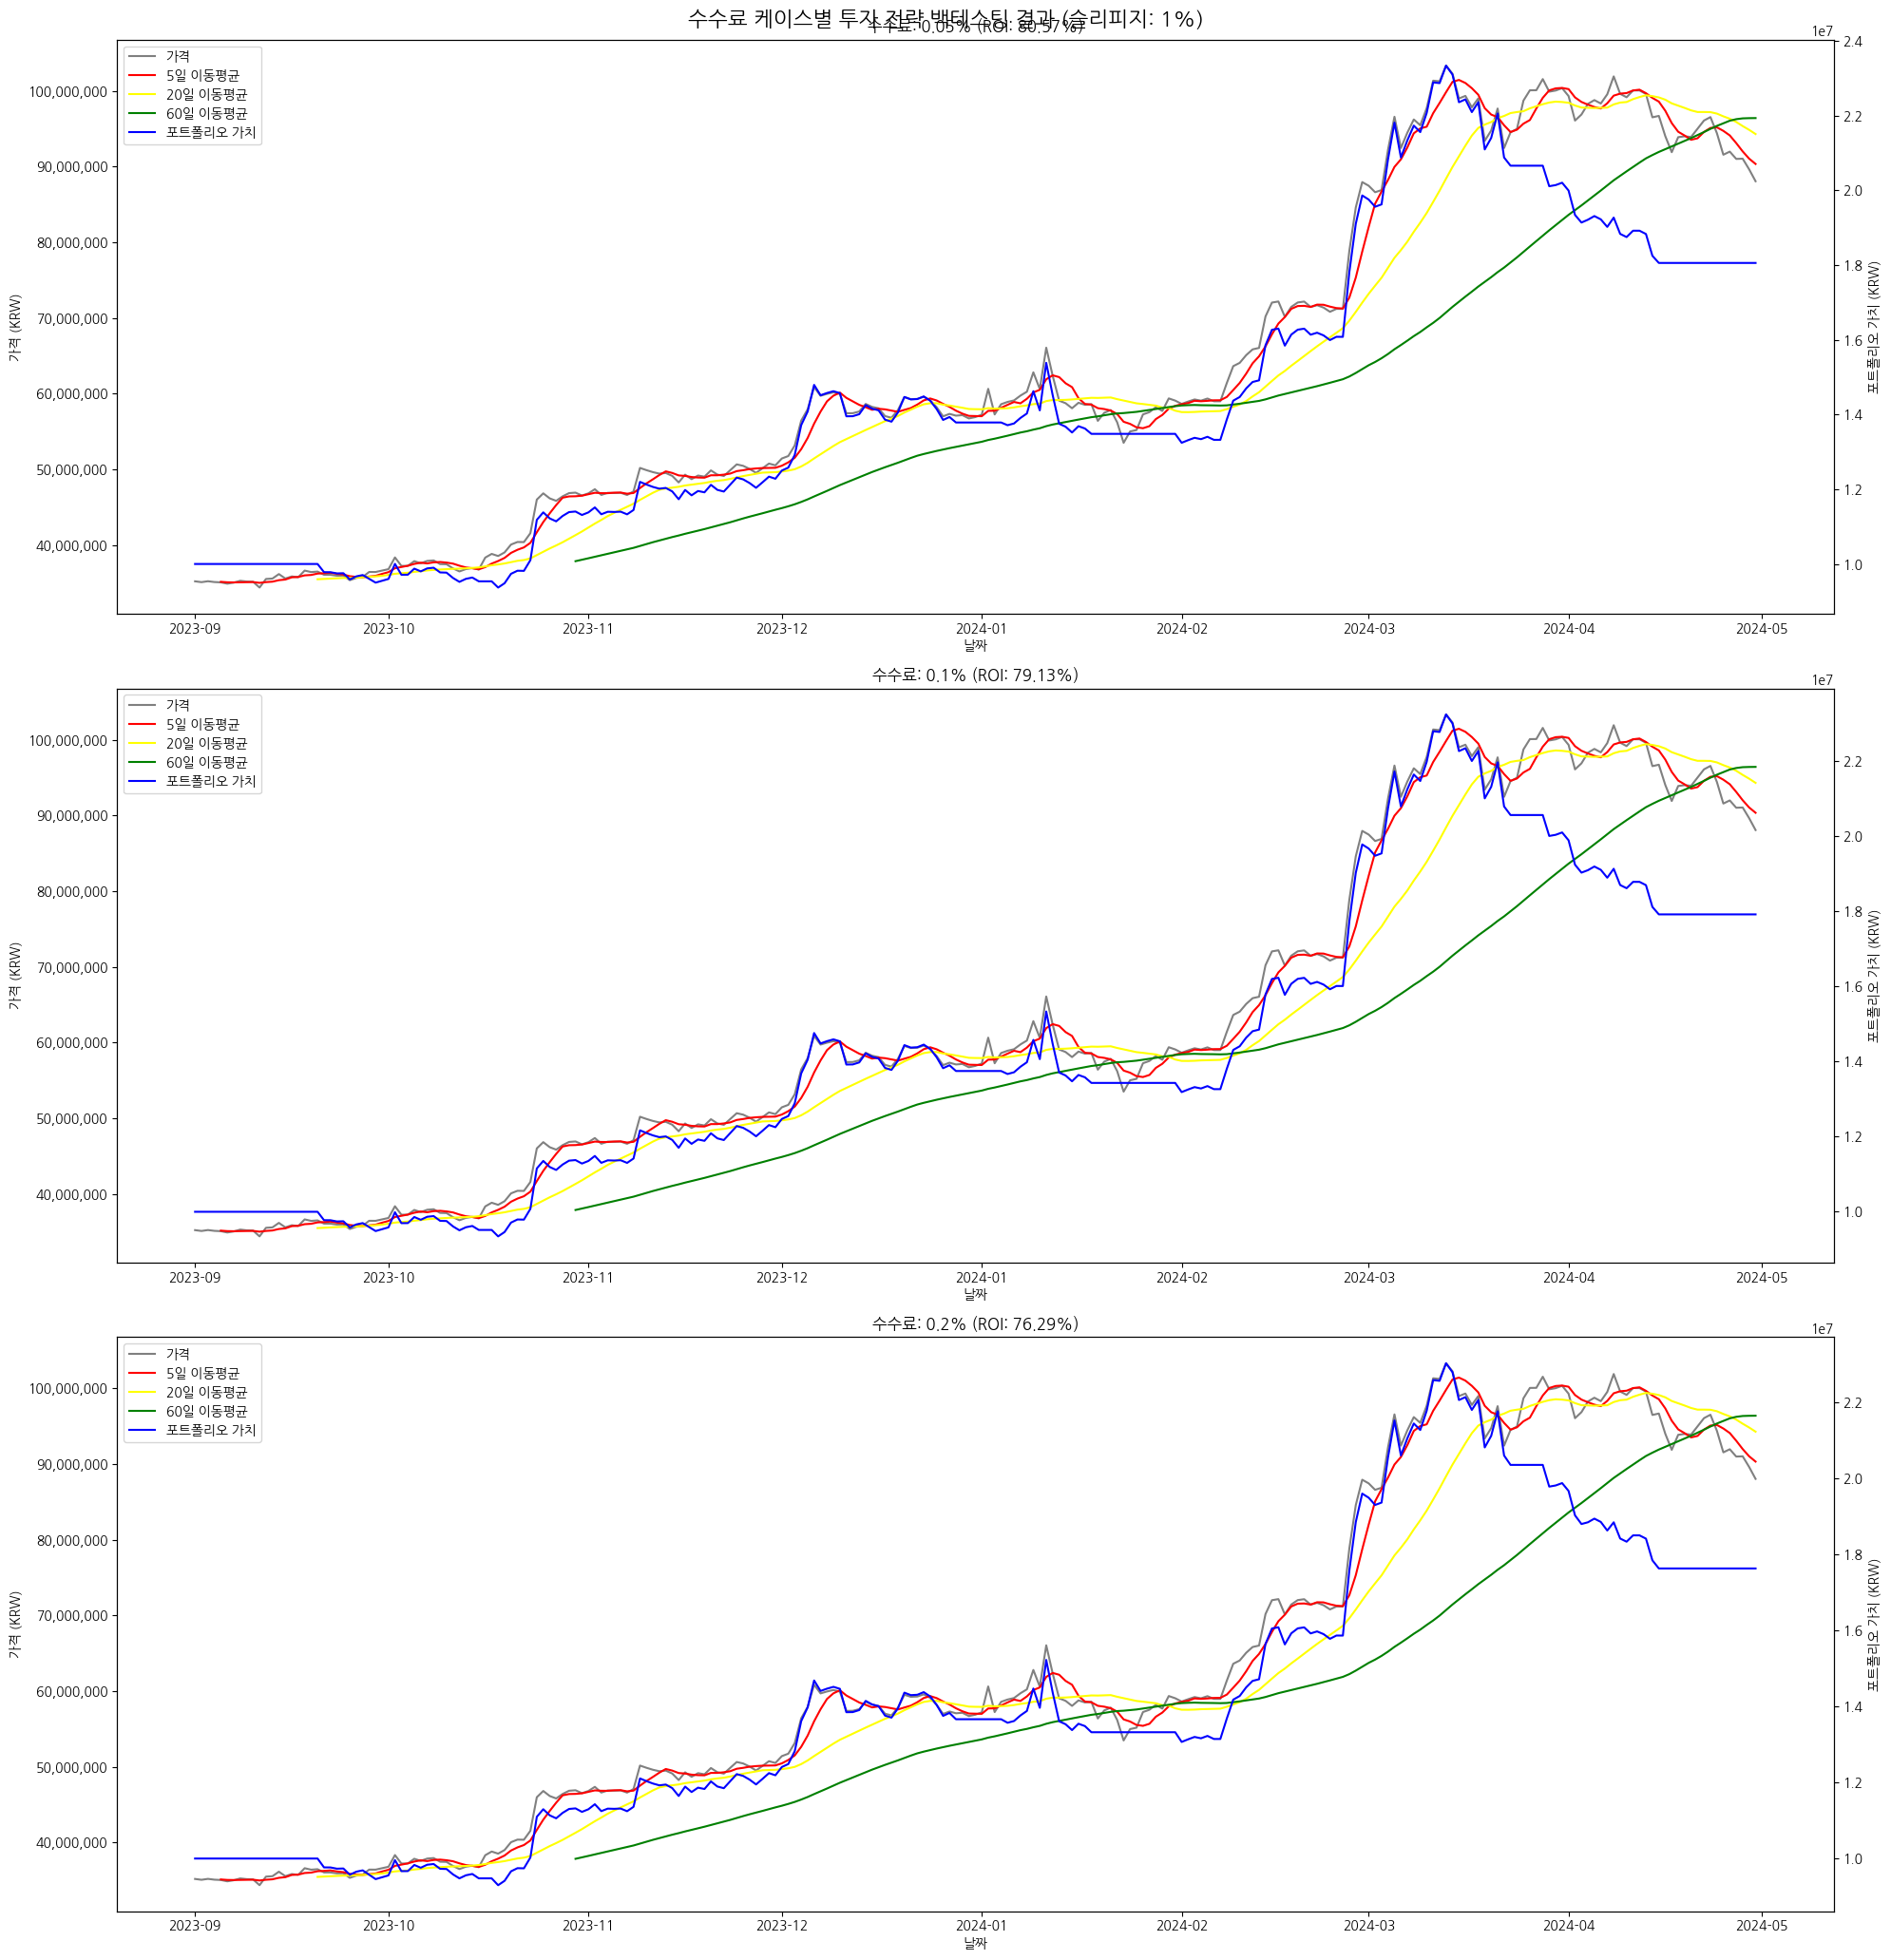


수수료 0.05% 케이스:
2023-09-20 매수: 0.27122104 비트코인 at 36,851,870 KRW
2023-09-27 매도: 0.27122104 비트코인 at 35,421,210 KRW
2023-09-28 매수: 0.26078853 비트코인 at 36,801,370 KRW
2023-10-14 매도: 0.26078853 비트코인 at 36,583,470 KRW
2023-10-17 매수: 0.24306847 비트코인 at 39,211,230 KRW
2023-12-27 매도: 0.24306847 비트코인 at 56,748,780 KRW
2024-01-04 매수: 0.23282621 비트코인 at 59,186,000 KRW
2024-01-17 매도: 0.23282621 비트코인 at 57,936,780 KRW
2024-01-31 매수: 0.22585732 비트코인 at 59,664,740 KRW
2024-03-22 매도: 0.22585732 비트코인 at 91,516,590 KRW
2024-03-28 매수: 0.20132533 비트코인 at 102,565,500 KRW
2024-04-02 손절 매도: 0.20132533 비트코인 at 95,109,300 KRW
2024-04-03 매수: 0.19550932 비트코인 at 97,840,720 KRW
2024-04-06 매도: 0.19550932 비트코인 at 97,339,770 KRW
2024-04-07 매수: 0.18910184 비트코인 at 100,537,420 KRW
2024-04-14 매도: 0.18910184 비트코인 at 95,535,000 KRW
초기 자본: 10,000,000 KRW
최종 포트폴리오 가치: 18,056,811 KRW
ROI: 80.57%

수수료 0.1% 케이스:
2023-09-20 매수: 0.27108556 비트코인 at 36,851,870 KRW
2023-09-27 매도: 0.27108556 비트코인 at 35,421,210 KRW
2023-09-28 매수: 0.260

In [16]:
# 세 가지 수수료 케이스에 대해 백테스트 실행
fee_rates = [0.0005, 0.001, 0.002]  # 0.05%, 0.1%, 0.2%
slippage_rate = 0.01  # 1% 슬리피지

fig, axes = plt.subplots(3, 1, figsize=(20, 21))
fig.suptitle('상승장 수수료 케이스별 투자 전략 백테스팅 결과 (슬리피지: 1%)', fontsize=16)

for i, fee_rate in enumerate(fee_rates):
    df_result, final_portfolio, initial_capital, roi = backtest_strategy(fee_rate, slippage_rate, return_data=True)
    
    ax1 = axes[i]
    ax2 = ax1.twinx()
    
    ax1.plot(df_result.index, df_result['close'], label='가격', color='gray')
    ax1.plot(df_result.index, df_result['MA5'], label='5일 이동평균', color='red')
    ax1.plot(df_result.index, df_result['MA20'], label='20일 이동평균', color='yellow')
    ax1.plot(df_result.index, df_result['MA60'], label='60일 이동평균', color='green')
    ax1.set_xlabel('날짜')
    ax1.set_ylabel('가격 (KRW)')
    ax1.tick_params(axis='y')
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

    ax2.plot(df_result.index, df_result['Portfolio'], label='포트폴리오 가치', color='blue')
    ax2.set_ylabel('포트폴리오 가치 (KRW)')
    ax2.tick_params(axis='y')

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    ax1.set_title(f'수수료: {fee_rate*100}% (ROI: {roi:.2f}%)')

plt.tight_layout()
plt.show()

for fee_rate in fee_rates:
    print(f"\n수수료 {fee_rate*100}% 케이스:")
    backtest_strategy(fee_rate, slippage_rate, print_results=True)

이 전략은 **이동 평균선**을 사용하여 비트코인 매매 신호를 생성하고, 슬리피지와 수수료, 그리고 손절매(Stop-Loss)를 고려한 트레이딩 전략입니다. 구체적인 매수, 매도, 홀딩 조건을 하나씩 설명드리겠습니다.

### 전략 개요

- **초기 자본**: 10,000,000원 (₩1,000만원)
- **거래 자산**: 비트코인 (BTC)
- **데이터 사용**: 비트코인 일간 가격 및 5일 이동 평균(MA5)과 20일 이동 평균(MA20)을 기반으로 신호를 생성
- **수수료 및 슬리피지**: 매매 시 거래 비용을 현실적으로 반영
- **손절매**: 매수 가격에서 5% 하락 시 손절매 실행

### 신호 생성

이동 평균선을 기준으로 매매 신호를 다음과 같이 생성합니다:

- **매수 신호(`Signal = 1`)**: 5일 이동 평균(MA5)이 20일 이동 평균(MA20)을 상향 돌파할 때
- **매도 신호(`Signal = -1`)**: 5일 이동 평균(MA5)이 20일 이동 평균(MA20)을 하향 돌파할 때
- **홀딩 신호(`Signal = 0`)**: 매매 신호가 없을 때

```python
df_2024_daily['Signal'] = 0
df_2024_daily['Signal'][df_2024_daily['MA5'] > df_2024_daily['MA20']] = 1
df_2024_daily['Signal'][df_2024_daily['MA5'] < df_2024_daily['MA20']] = -1
```

### 매매 조건

#### **1. 매수 조건**

**매수 시점**:

- **매수 신호 발생(`Signal = 1`)**: MA5가 MA20을 상향 돌파하는 경우
- **보유 중인 비트코인이 없을 때**: 현재 비트코인을 보유하고 있지 않은 상태에서만 매수 가능

**실행 과정**:

- **슬리피지 적용**: 시장에 영향을 고려해 매수 가격을 약간 높게 계산.

  ```python
  buy_price = price * (1 + slippage_rate)
  ```

- **매수 가능 수량 계산**: 수수료를 고려한 후 매수할 수 있는 비트코인 수량을 계산.

  ```python
  holding = (capital / buy_price) / (1 + fee_rate)
  ```

- **매수 가격 기록**: 나중에 손절매 조건에 사용할 매수 가격을 저장.

  ```python
  entry_price = buy_price
  ```

- **자본 업데이트**: 모든 자본이 비트코인에 투자되었으므로 현금을 0으로 설정.

  ```python
  capital = 0
  ```

**요약**:

- **상승 신호**가 발생하고 비트코인을 보유하지 않을 때 **비트코인을 매수**합니다.
- **슬리피지 및 수수료**를 고려해 실제 매수 가능 수량을 계산합니다.
- **매수 가격을 기록**하여 손절매 조건에 대비합니다.

#### **2. 매도 조건**

**매도 시점**:

- **매도 신호 발생(`Signal = -1`)**: MA5가 MA20을 하향 돌파하는 경우
- **보유 중인 비트코인이 있을 때**: 비트코인을 이미 보유 중일 때만 매도 가능

**실행 과정**:

- **슬리피지 적용**: 시장에 영향을 고려해 매도 가격을 약간 낮게 계산.

  ```python
  sell_price = price * (1 - slippage_rate)
  ```

- **매도 후 자본 계산**: 수수료를 고려하여 매도 후 확보할 자본을 계산.

  ```python
  capital = holding * sell_price * (1 - fee_rate)
  ```

- **보유 수량 업데이트**: 모든 비트코인을 매도하였으므로 보유 수량을 0으로 설정.

  ```python
  holding = 0
  ```

**요약**:

- **하락 신호**가 발생하고 비트코인을 보유 중일 때 **비트코인을 전량 매도**합니다.
- **슬리피지와 수수료**를 고려해 매도 후 자본을 정확히 계산합니다.
- **보유 비트코인 수량을 0**으로 설정하여 다음 거래에 대비합니다.

#### **3. 손절매 조건**

**손절매 시점**:

- **보유 중인 비트코인이 있을 때**: 비트코인을 보유한 상태에서만 손절매 가능
- **가격이 손절매 기준 이하로 떨어질 때**: 현재 가격이 매수 가격에서 5% 이상 하락한 경우

  ```python
  price <= entry_price * (1 - stop_loss)
  ```

**실행 과정**:

- **슬리피지 적용**: 급격한 가격 하락을 고려하여 매도 가격을 낮게 설정.

  ```python
  sell_price = price * (1 - slippage_rate)
  ```

- **손절매 후 자본 계산**: 수수료를 고려한 후 손절매를 통해 회수한 자본을 계산.

  ```python
  capital = holding * sell_price * (1 - fee_rate)
  ```

- **보유 수량 업데이트**: 손절매 후 보유한 비트코인을 0으로 설정.

  ```python
  holding = 0
  ```

**요약**:

- **가격이 매수 가격 대비 5% 이상 하락**할 경우 손절매를 실행하여 손실을 줄입니다.
- **슬리피지와 수수료**를 고려해 매도 후 자본을 계산합니다.
- **보유 비트코인 수량을 0**으로 설정하여 추가 손실을 방지합니다.

#### **4. 홀딩 조건**

**홀딩 시점**:

- **매수 또는 매도 신호가 없을 때**: 이동 평균선의 크로스가 발생하지 않을 때
- **손절매 조건에 해당하지 않을 때**: 가격이 손절매 기준에 도달하지 않을 때

**실행 과정**:

- **아무런 행동도 하지 않음**: 현재 상태를 유지하며 다음 신호를 기다립니다.

**요약**:

- **시장에 매수, 매도 신호가 없고** 손절매 기준에도 해당하지 않을 때 현재 자산을 그대로 **홀딩**합니다.
- **다음 신호**가 발생할 때까지 자산을 유지하며 대기합니다.

### 추가 요소

- **포트폴리오 가치 추적**: 현재 현금과 비트코인 보유량을 이용해 매일 포트폴리오 가치를 업데이트합니다.

  ```python
  portfolio_value = capital + holding * price
  portfolio_values.append(portfolio_value)
  ```

- **거래 내역 출력**: `print_results=True`로 설정하면 각 거래의 날짜, 거래 유형, 비트코인 수량, 가격을 기록합니다.

### 전략 요약

- **목표**: 단기적인 상승 트렌드를 따라 비트코인을 매수하고, 하락 신호 시 매도하여 수익을 실현합니다. 하락 시에는 손절매를 통해 손실을 제한합니다.
- **위험 관리**: 5%의 손절매 설정을 통해 가격 급락 시 손실을 최소화합니다.
- **거래 비용 고려**: 슬리피지와 수수료를 반영하여 더 현실적인 거래 성과를 시뮬레이션합니다.
- **신호 의존성**: 이동 평균선의 크로스 신호를 사용하여 매매를 결정합니다. 횡보장에서는 신호가 부정확할 수 있습니다.

### 예시 시나리오

- **1일차**: MA5가 MA20을 상향 돌파.
  - **행동**: 비트코인 매수.
  - **이유**: 상승 신호가 발생하였으며, 현재 비트코인을 보유하고 있지 않음.
- **5일차**: 가격이 매수 가격 대비 5% 하락.
  - **행동**: 손절매 실행.
  - **이유**: 손실을 줄이기 위해 가격 하락 시 손절매.
- **10일차**: MA5가 MA20을 하향 돌파.
  - **행동**: 아무 행동 안 함.
  - **이유**: 현재 비트코인을 보유하고 있지 않으므로 매도 불가능.
- **15일차**: MA5가 다시 MA20을 상향 돌파.
  - **행동**: 비트코인 매수.
  - **이유**: 새로운 상승 신호가 발생했으므로 매수.

### 결론

이 전략은 **추세 추종 전략**으로, 상승 추세를 따르며 수익을 추구하고, 손실을 제한하기 위해 **

손절매**를 사용합니다. **슬리피지와 수수료**를 반영하여 현실적인 거래 성과를 예측하고, **이동 평균선 크로스** 신호를 기반으로 매매 결정을 내립니다.

## 하락장에서 동일한 전략으로
어떤 매수 & 매도 전략을 펼치는지 관찰

In [17]:
df_2022 = df['2022-01-01':'2023-08-31']

In [18]:
# 5일 이동평균 계산
# 일일 데이터로 리샘플링
df_2022_daily = df_2022.resample('D').agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last', 'volume': 'sum', 'value': 'sum'})

# 일일 데이터에 대한 이동평균 계산
df_2022_daily['MA5'] = df_2022_daily['close'].rolling(window=5).mean()
df_2022_daily['MA20'] = df_2022_daily['close'].rolling(window=20).mean()
df_2022_daily['MA60'] = df_2022_daily['close'].rolling(window=60).mean()
# 1일 변동성 계산
df_2022_daily['변동성'] = (df_2022_daily['high'] - df_2022_daily['low']) / df_2022_daily['open'] * 100

In [19]:
def backtest_strategy(fee_rate, slippage_rate, print_results=False, return_data=False):
    # 초기 자본 설정
    initial_capital = 10_000_000  # 1,000만원
    capital = initial_capital
    position = 0  # 보유 현금
    holding = 0  # 보유 비트코인 수량
    entry_price = 0  # 매수 가격
    portfolio_values = []  # 포트폴리오 가치 저장
    stop_loss = 0.05  # 5% 손실 제한

    # 매매 신호 생성 (예: MA5가 MA20을 상향 돌파 시 매수, 하향 돌파 시 매도)
    df_2022_daily['Signal'] = 0
    df_2022_daily['Signal'][df_2022_daily['MA5'] > df_2022_daily['MA20']] = 1
    df_2022_daily['Signal'][df_2022_daily['MA5'] < df_2022_daily['MA20']] = -1

    for idx, row in df_2022_daily.iterrows():
        price = row['close']
        signal = row['Signal']

        # 포트폴리오 가치 업데이트
        portfolio_value = capital + holding * price
        portfolio_values.append(portfolio_value)

        # 매수 조건
        if signal == 1 and holding == 0:
            # 슬리피지 적용
            buy_price = price * (1 + slippage_rate)
            # 수수료를 고려한 매수 가능 수량 계산
            holding = (capital / buy_price) / (1 + fee_rate)
            entry_price = buy_price
            capital = 0
            if print_results:
                print(f"{idx.date()} 매수: {holding:.8f} 비트코인 at {buy_price:,.0f} KRW")

        # 매도 조건
        elif signal == -1 and holding > 0:
            # 슬리피지 적용
            sell_price = price * (1 - slippage_rate)
            capital = holding * sell_price * (1 - fee_rate)
            if print_results:
                print(f"{idx.date()} 매도: {holding:.8f} 비트코인 at {sell_price:,.0f} KRW")
            holding = 0

        # 손절 조건
        elif holding > 0 and (price <= entry_price * (1 - stop_loss)):
            # 슬리피지 적용
            sell_price = price * (1 - slippage_rate)
            capital = holding * sell_price * (1 - fee_rate)
            if print_results:
                print(f"{idx.date()} 손절 매도: {holding:.8f} 비트코인 at {sell_price:,.0f} KRW")
            holding = 0

    # 최종 포트폴리오 가치 업데이트
    final_portfolio = capital + holding * df_2024_daily['close'].iloc[-1]
    portfolio_values[-1] = final_portfolio

    # 포트폴리오 가치 데이터프레임 생성
    df_2022_daily['Portfolio'] = portfolio_values

    # ROI 계산
    roi = (final_portfolio - initial_capital) / initial_capital * 100

    if print_results:
        print(f"초기 자본: {initial_capital:,.0f} KRW")
        print(f"최종 포트폴리오 가치: {final_portfolio:,.0f} KRW")
        print(f"ROI: {roi:.2f}%")

    if return_data:
        return df_2022_daily, final_portfolio, initial_capital, roi
    else:
        return roi

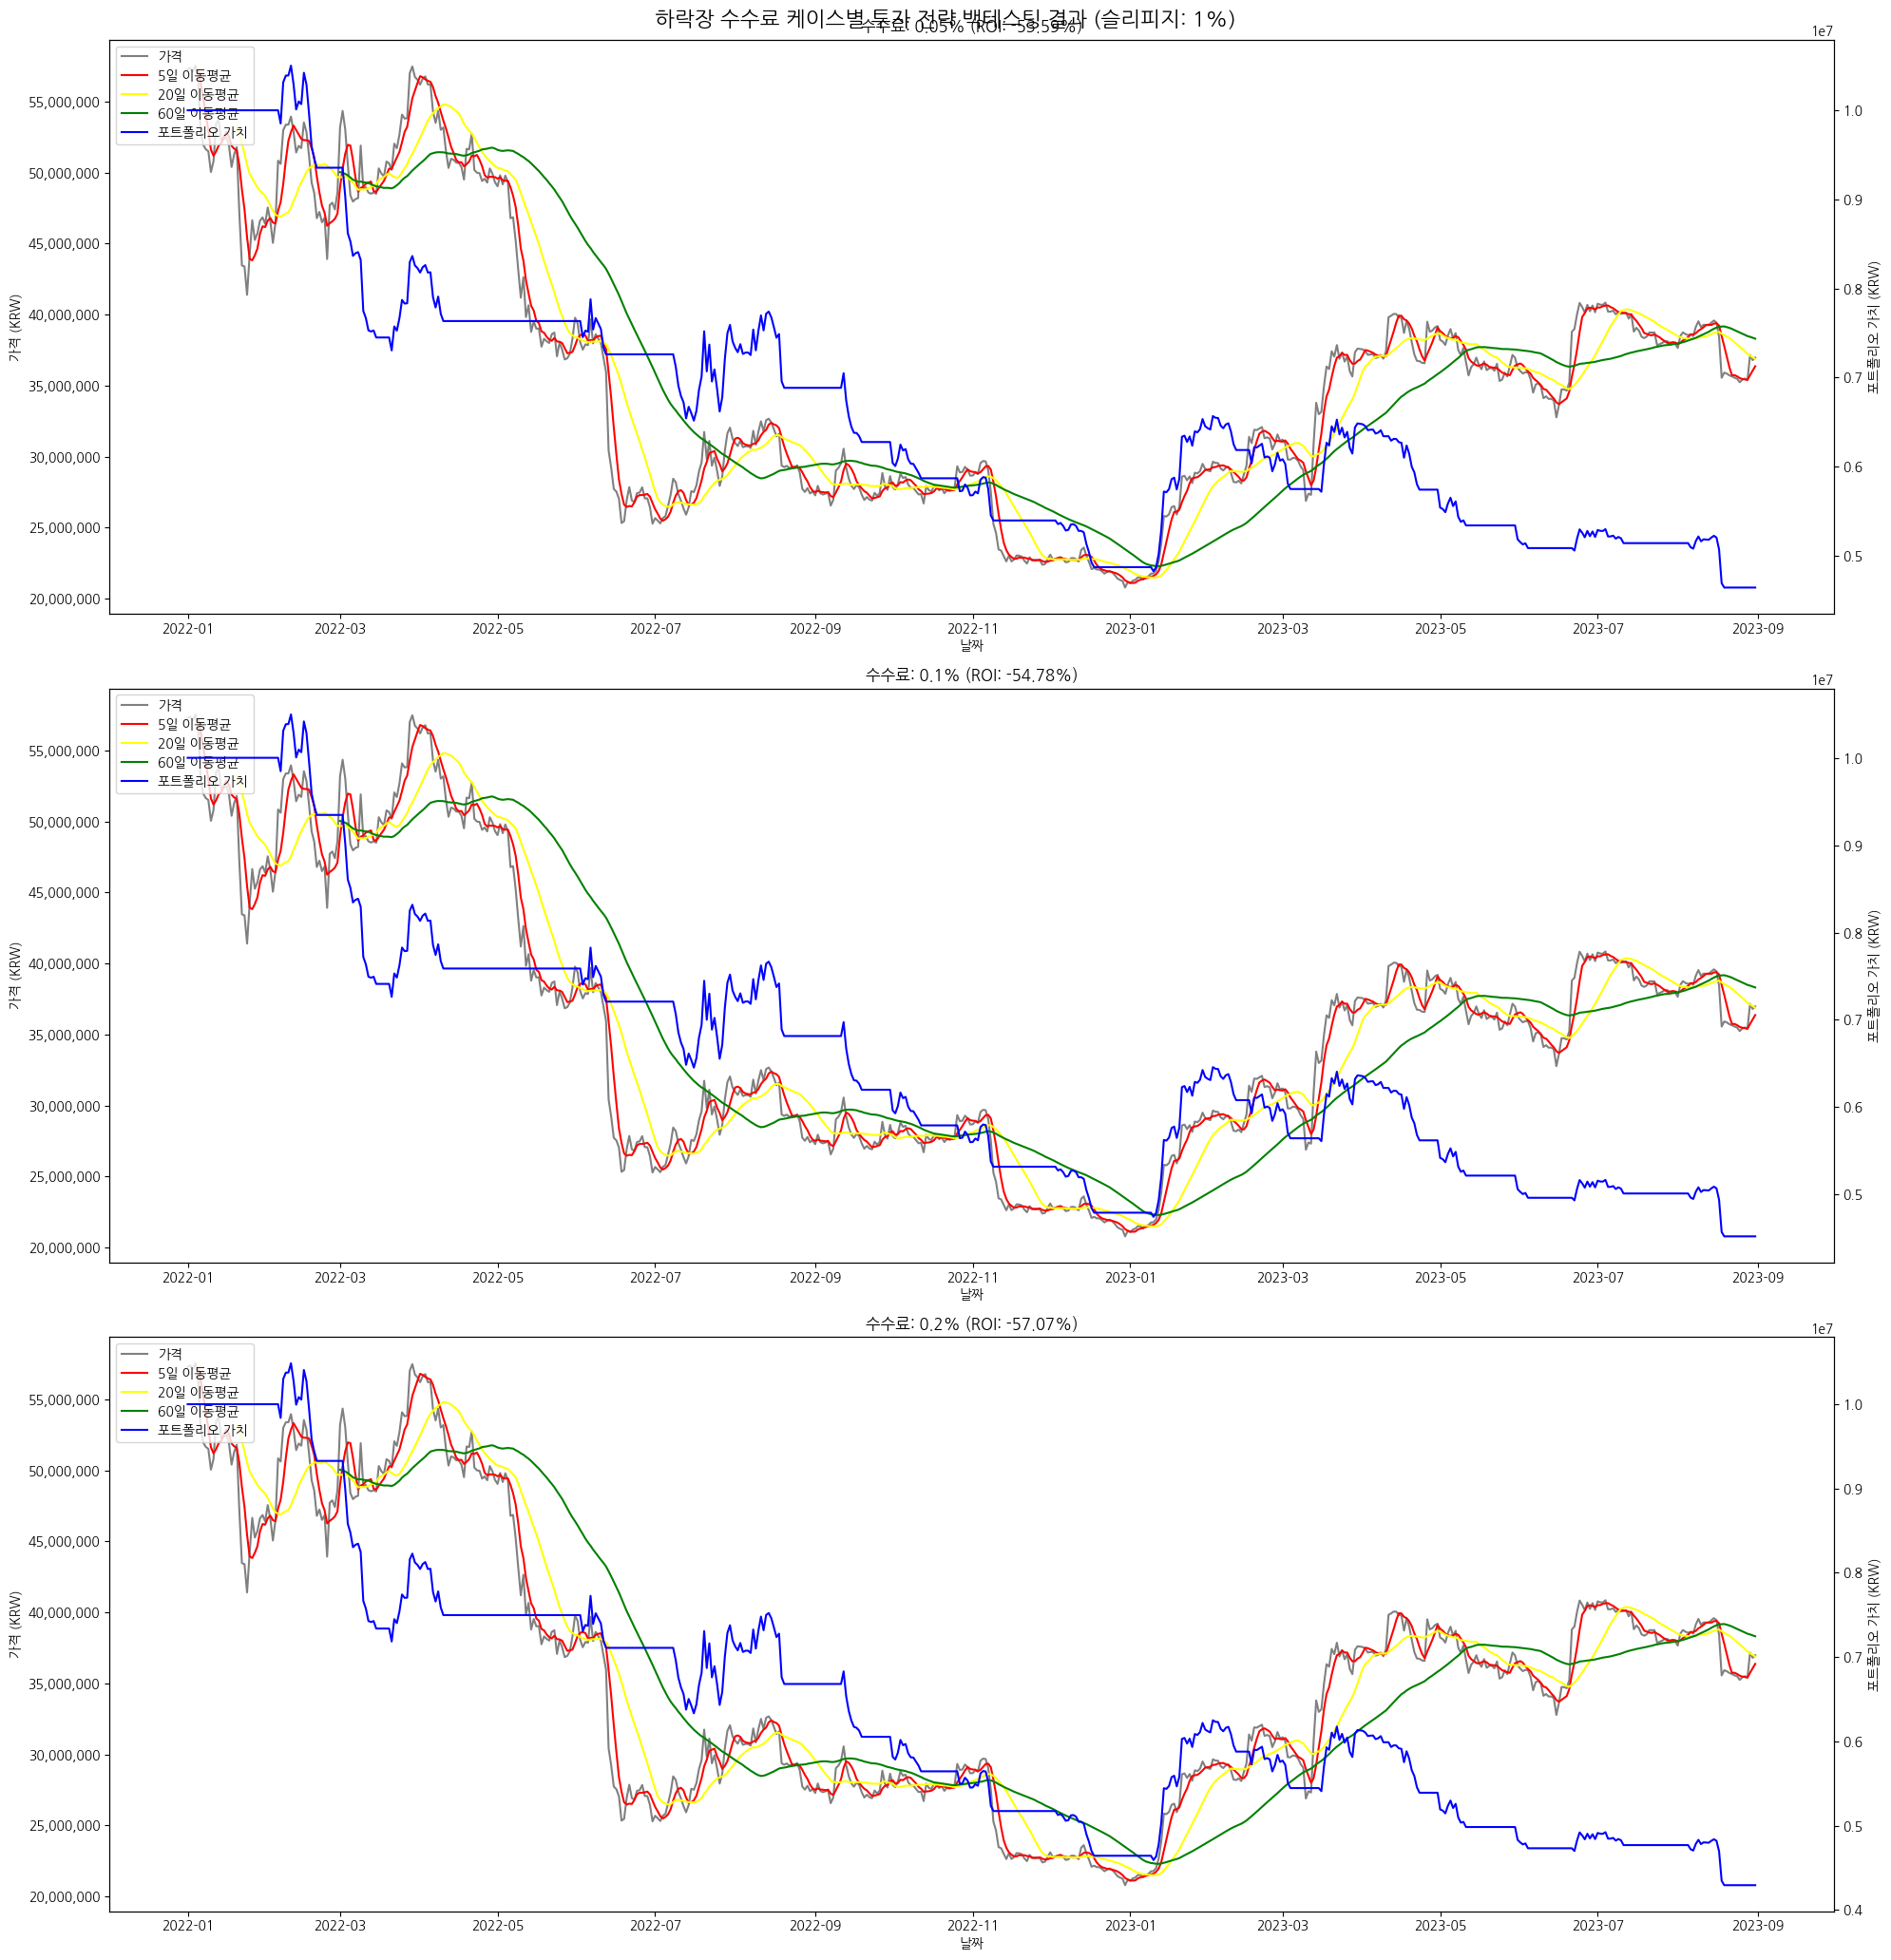


수수료 0.05% 케이스:
2022-02-05 매수: 0.19464305 비트코인 at 51,350,420 KRW
2022-02-19 손절 매도: 0.19464305 비트코인 at 48,087,270 KRW
2022-03-02 매수: 0.17034829 비트코인 at 54,890,470 KRW
2022-03-04 손절 매도: 0.17034829 비트코인 at 50,091,030 KRW
2022-03-05 매수: 0.17439803 비트코인 at 48,878,950 KRW
2022-03-08 매도: 0.17439803 비트코인 at 47,724,930 KRW
2022-03-09 매수: 0.15859466 비트코인 at 52,428,090 KRW
2022-03-10 손절 매도: 0.15859466 비트코인 at 48,361,500 KRW
2022-03-11 매수: 0.15490558 비트코인 at 49,463,740 KRW
2022-03-14 매도: 0.15490558 비트코인 at 48,111,030 KRW
2022-03-20 매수: 0.14551509 비트코인 at 51,164,580 KRW
2022-04-09 매도: 0.14551509 비트코인 at 52,485,840 KRW
2022-06-02 매수: 0.19851539 비트코인 at 38,434,540 KRW
2022-06-11 매도: 0.19851539 비트코인 at 36,588,420 KRW
2022-07-08 매수: 0.25252240 비트코인 at 28,734,500 KRW
2022-07-11 손절 매도: 0.25252240 비트코인 at 26,631,000 KRW
2022-07-12 매수: 0.25236884 비트코인 at 26,620,570 KRW
2022-07-14 매도: 0.25236884 비트코인 at 26,167,680 KRW
2022-07-15 매수: 0.23686357 비트코인 at 27,852,770 KRW
2022-08-19 매도: 0.23686357 비트코인 at 29,076,

In [20]:
# 세 가지 수수료 케이스에 대해 백테스트 실행
fee_rates = [0.0005, 0.001, 0.002]  # 0.05%, 0.1%, 0.2%
slippage_rate = 0.01  # 1% 슬리피지

fig, axes = plt.subplots(3, 1, figsize=(20, 21))
fig.suptitle('하락장 수수료 케이스별 투자 전략 백테스팅 결과 (슬리피지: 1%)', fontsize=16)

for i, fee_rate in enumerate(fee_rates):
    df_result, final_portfolio, initial_capital, roi = backtest_strategy(fee_rate, slippage_rate, return_data=True)
    
    ax1 = axes[i]
    ax2 = ax1.twinx()
    
    ax1.plot(df_result.index, df_result['close'], label='가격', color='gray')
    ax1.plot(df_result.index, df_result['MA5'], label='5일 이동평균', color='red')
    ax1.plot(df_result.index, df_result['MA20'], label='20일 이동평균', color='yellow')
    ax1.plot(df_result.index, df_result['MA60'], label='60일 이동평균', color='green')
    ax1.set_xlabel('날짜')
    ax1.set_ylabel('가격 (KRW)')
    ax1.tick_params(axis='y')
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

    ax2.plot(df_result.index, df_result['Portfolio'], label='포트폴리오 가치', color='blue')
    ax2.set_ylabel('포트폴리오 가치 (KRW)')
    ax2.tick_params(axis='y')

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    ax1.set_title(f'수수료: {fee_rate*100}% (ROI: {roi:.2f}%)')

plt.tight_layout()
plt.show()

for fee_rate in fee_rates:
    print(f"\n수수료 {fee_rate*100}% 케이스:")
    backtest_strategy(fee_rate, slippage_rate, print_results=True)

## 개선 해볼 사항

손절율을 좀 더 높게 설정하고 수익이 나고 있을 때 최대한 늘리는 전략으로 한번 테스트 해볼 필요가 있음.